# Getting Started with pyNSID

A fast  introduction to an easy to use but comprehensive data format.

pyNSID is based on pyUSID and part of pycroscopy 

pyNSID has two forms. 
- a front end that is based on dask
- a back end to store the data in an hdf5 dataset

First we load the usual supsects

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook 

# import pyNSID (the basic way at this point)
import os, sys
sys.path.append('../../')
import pyNSID as nsid

Populating the interactive namespace from numpy and matplotlib


First we make a random data set in numpy

In [2]:
random_data = np.random.random((3,100,100))

Now we make a NSID dask dataset out of it

In [3]:
data = nsid.io.NSIDask.from_array(random_data)

## Dimensions
This was not that hard, but a dataset alone would not be very usefull, a NSID dask dataset has a lot of attributes important for microscopy data.
for one thing the axes are actually scales. Lets add them. 

We pretend that the random data here are a stack of images with the first dimension the time axis. We set the two dimensions of the image plane first.

With the ``set_dimension`` function we set the ``dimension`` and the respective `` nsid.Dimension`` dataset.

A ``nsid.Dimension`` consists of a 
- label (here: x, y)
- a numpy array of numbers here with a pixel size of 0.145 nm
- a quanitity (here: distance)
- a unit (here: nm)
- a dimension type: (here: spatial)

In [4]:
data.set_dimension(1,nsid.Dimension('x', np.arange(random_data.shape[1])*.0145, 
                                    'distance', 'nm', 'spatial' ))
data.set_dimension(2,nsid.Dimension('y', np.arange(random_data.shape[2])*.0145, 
                                    'distance', 'nm', 'spatial' ))


We can now access these additional dimensional information

In [5]:
print(data.x)
print('units of y-axis :',data.y.units)
print('quantity of x-axis :',data.x.quantity)
print('values of y-axis :',data.y.values)


x - distance (nm): [0.     0.0145 0.029  0.0435 0.058  0.0725 0.087  0.1015 0.116  0.1305
 0.145  0.1595 0.174  0.1885 0.203  0.2175 0.232  0.2465 0.261  0.2755
 0.29   0.3045 0.319  0.3335 0.348  0.3625 0.377  0.3915 0.406  0.4205
 0.435  0.4495 0.464  0.4785 0.493  0.5075 0.522  0.5365 0.551  0.5655
 0.58   0.5945 0.609  0.6235 0.638  0.6525 0.667  0.6815 0.696  0.7105
 0.725  0.7395 0.754  0.7685 0.783  0.7975 0.812  0.8265 0.841  0.8555
 0.87   0.8845 0.899  0.9135 0.928  0.9425 0.957  0.9715 0.986  1.0005
 1.015  1.0295 1.044  1.0585 1.073  1.0875 1.102  1.1165 1.131  1.1455
 1.16   1.1745 1.189  1.2035 1.218  1.2325 1.247  1.2615 1.276  1.2905
 1.305  1.3195 1.334  1.3485 1.363  1.3775 1.392  1.4065 1.421  1.4355]
units of y-axis : nm
quantity of x-axis : distance
values of y-axis : [0.     0.0145 0.029  0.0435 0.058  0.0725 0.087  0.1015 0.116  0.1305
 0.145  0.1595 0.174  0.1885 0.203  0.2175 0.232  0.2465 0.261  0.2755
 0.29   0.3045 0.319  0.3335 0.348  0.3625 0.377  0.3915 0

## Plotting
Because we specified the x and y axis as having a dimension_type of ``spatial``, we can already use this information and plot the data as image;

This function is available also in the NSID dask dataset. (TODO)

<IPython.core.display.Javascript object>


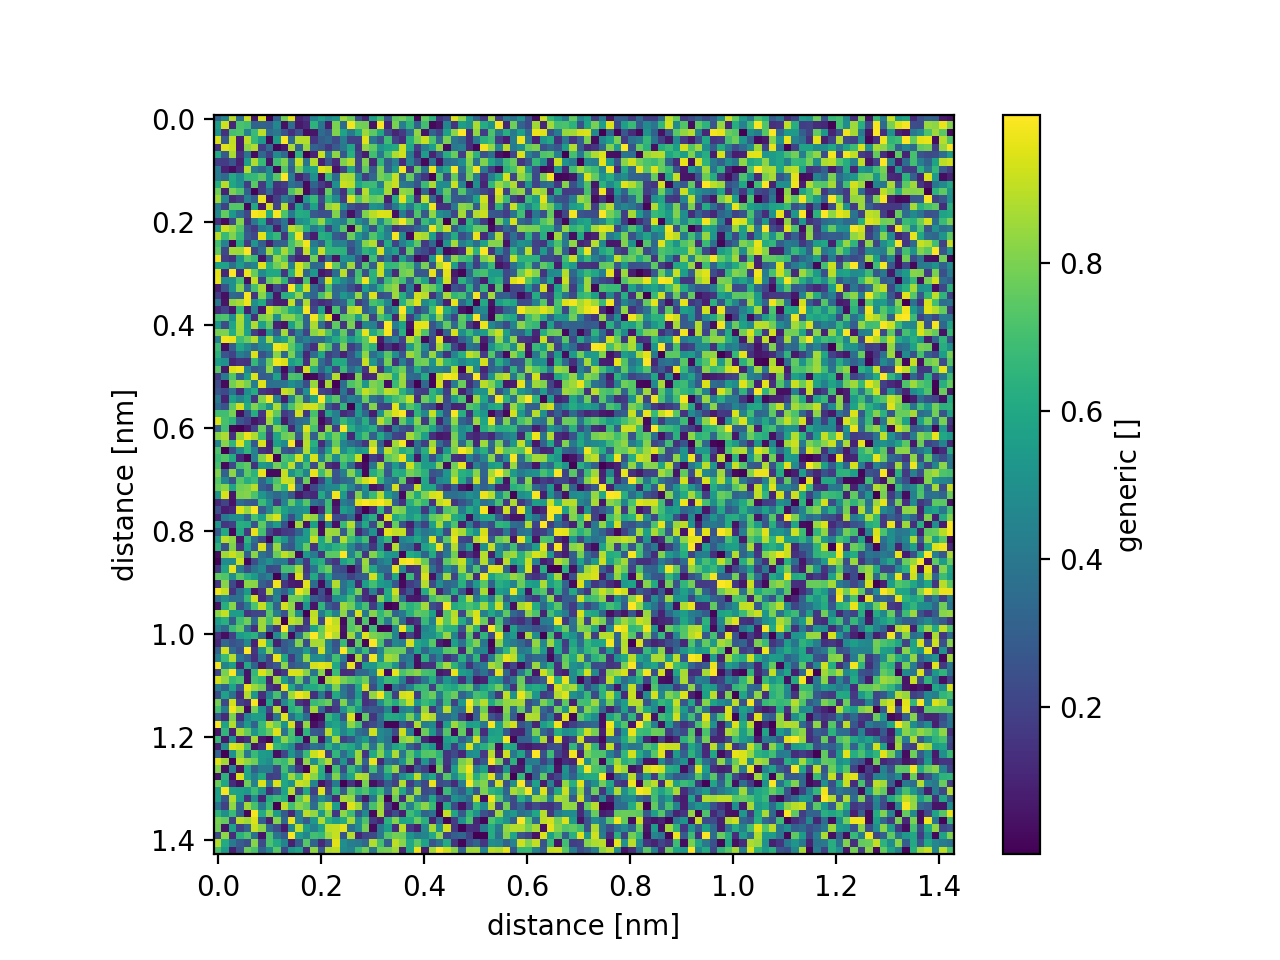

In [6]:
def plot_image(data):
    """
    plotting of data according to two axis marked as 'spatial' in the dimensions
    """
    selection = []
    image_dims = []
    for  dim, axis in data.axes.items():
        if axis.dimension_type == 'spatial':
            selection.append(slice(None))
            image_dims.append(dim)
        else:
            selection.append(slice(0,1))
    if len(image_dims) != 2:
        raise ValueError('We need two dimensions with dimension_type spatial to plot an image')

    plt.figure()
    plt.title(data.title)
    img = plt.imshow(data[tuple(selection)].T, extent = data.get_extent(image_dims))
    plt.xlabel(f"{data.x.quantity} [{data.x.units}]")
    plt.ylabel(f"{data.y.quantity} [{data.y.units}]")
    cbar = plt.colorbar(img)
    cbar.set_label(f"{data.quantity} [{data.units}]")

    plt.show()

plot_image(data)


## Other Metadata
As we see from the label of thee color bar on the right of above graph, the dataset should be providing a few more information. Let's set that.

<IPython.core.display.Javascript object>


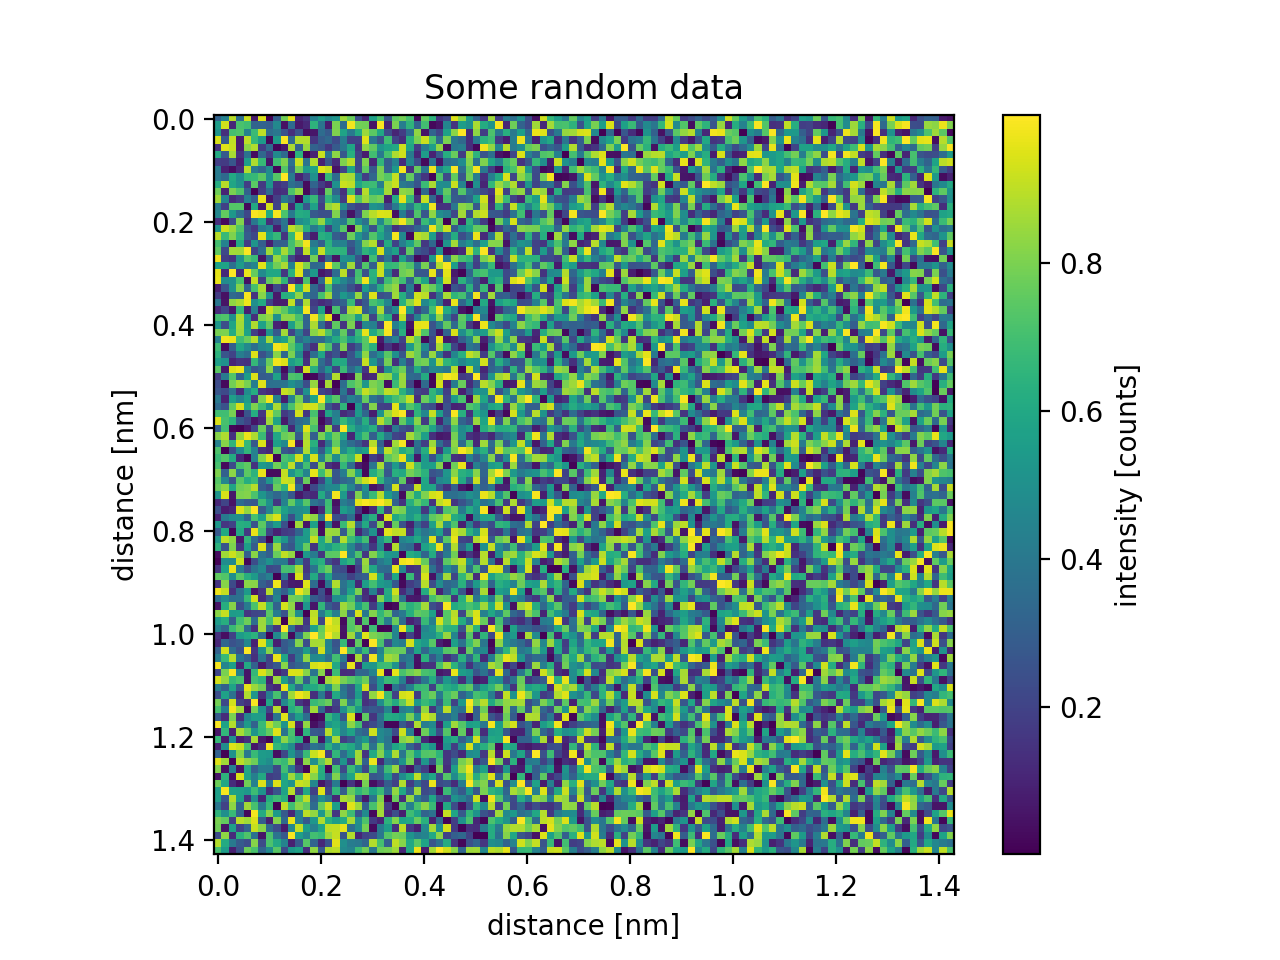

In [7]:
data.title = 'Some random data'
data.quantity = 'intensity'
data.units = 'counts'
plot_image(data);


There are a few other attributes we can set: Most importantly the stack dimension but also:
- data_type = 'image_stack'
- modality = '?'
- source = 'numpy random number genrator'
- data_descriptor = ''

In [8]:
data.set_dimension(0,nsid.Dimension('stack', np.arange(random_data.shape[0]), 
                                  'time', 'frame', 'time' ))

data.data_type = 'image_stack'
data.modality = '?'
data.source = 'numpy random number genrator'
data.data_descriptor = 'something'

## Additional Metadata
the ``attrs`` attribute holds a python dictionary that can be populated with all kinds of useful information. Beware, this has to be a simple dictionary, so ``no dictionary of a dictionary`` ...


In [9]:
data.attrs={'created by': 'notebook'}
data.attrs['The number'] = 42
data.attrs['errors'] = [2,6,4,8,100]


## Save to file
We created a fully functioning NSID dataset. Now let's save it.
We need a hdf5 file and a group in that file, which we hand over to the ``to_hdf5`` function.

In [10]:
import h5py
h5_file = h5py.File('test', mode='a')
if 'Measurement_000/Channel_000' not in h5_file:
    h5_group = h5_file.create_group('Measurement_000/Channel_000')
h5_group = h5_file['Measurement_000/Channel_000']

In [11]:
data.to_hdf5(h5_group)

Let's look at the data file

In [12]:
 nsid.hdf_utils.print_tree(h5_file)

/
├ Mearuement_000
  --------------
  ├ Channel_000
    -----------
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Some random data
    ├ stack
    ├ x
    ├ y


And we close the file

In [13]:
h5_file.close()